<a href="https://colab.research.google.com/github/JuliaKoryukova/Neural-Networks/blob/main/02_%D0%A8%D1%83%D0%BC%D0%BE%D0%BF%D0%BE%D0%B4%D0%B0%D0%B2%D0%BB%D1%8F%D1%8E%D1%89%D0%B8%D0%B9_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Шумоподавляющий autoencoder**

---



# Импорты и загрузка MNIST

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
from typing import List, Tuple, Dict
from IPython.display import clear_output
from torchsummary import summary
from PIL import Image

import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.ToTensor()

train_dataset = MNIST(
    root='data',
    train=True,
    transform=transform,
    download=True,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

test_dataset = MNIST(
    root='data',
    train=False,
    transform=transform,
    download=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15069030.47it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 464027.20it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4155765.16it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3470041.67it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
images_train, labels_train = next(iter(train_loader))

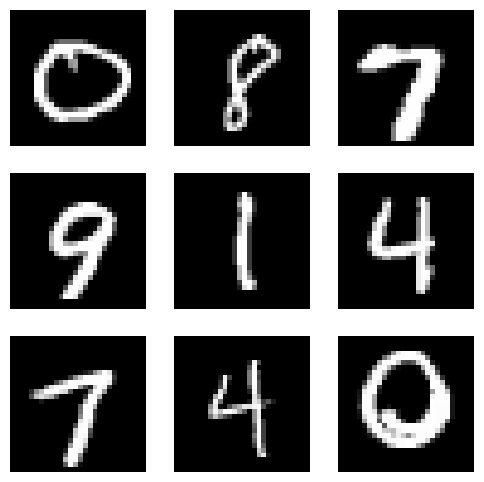

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for ax, image in zip(axes.flatten(), images_train):
    ax.imshow(image.squeeze().numpy(), cmap='gray')
    ax.grid(False)
    ax.set_axis_off()

plt.show()

In [ ]:
images_train.shape, labels_train.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

# Линейная модель

Класс модели линейного автоэнкодера

In [ ]:
class AutoEncoder_Linear(nn.Module):
    def __init__(self, input_size: Tuple[int], hidden_size: int, latent_size: int):
        super().__init__()

        # Параметры модели
        self.input_size = input_size
        self.flattened_size = np.prod(input_size)

        # сеть энкодер
        self.encoder = nn.Sequential(
            nn.Flatten(), # выравнивает в одномерный тензор для подачи в полносвязный слой
            nn.Linear(self.flattened_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, latent_size),
            )

        # сеть декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.flattened_size),
            nn.Unflatten(dim=1, unflattened_size=input_size),
            nn.Sigmoid()
            )

    # forward pass через энкодер и декодер
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon

    # forward pass через энкодер на инференсе
    @torch.inference_mode()
    def encode(self, image: torch.Tensor) -> torch.Tensor:
        latent = self.encoder(image)
        return latent

    # forward pass через декодер на инференсе
    @torch.inference_mode()
    def decode(self, latent: torch.Tensor) -> torch.Tensor:
        recon = self.decoder(latent)
        return recon


Инициализация модели

In [ ]:
torch.manual_seed(42)

input_size = (1, 28, 28)
hidden_size = 128 # размерность промежуточных линейных слоев
latent_size = 32 # размерность скрытого пространства

autoencoder = AutoEncoder_Linear(input_size, hidden_size, latent_size) # создание модели
autoencoder = autoencoder.to(device) # переместить модель на девайс

lr = 0.001 # скорость обучения
opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_fn = nn.MSELoss()

Обучение автоэнкодера

In [ ]:
noise_factor = 0.3

In [ ]:
def add_noise(images: torch.Tensor, noise_factor: float) -> torch.Tensor:
    noise = torch.randn_like(images) * noise_factor
    noise_images = images + noise
    return noise_images.clip(0, 1)

In [ ]:
def train_autoencoder(
        ae: nn.Module,
        train_loader: DataLoader,
        test_loader: DataLoader,
        loss_fn: nn.Module,
        opt: torch.optim.Optimizer,
        epochs: int,
        writer: SummaryWriter = None,
        print_every: int = 1,
        ) -> Tuple[List[float], List[float]]:

    ae.train()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        epoch_train_loss = 0

        # Обучение на тренировочной выборке
        for images, _ in train_loader:
            noisy_images = add_noise(images, noise_factor).to(device)
            images = images.to(device)

            recon_images = ae(noisy_images)
            loss = loss_fn(recon_images, images)
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Валидация на тестовой выборке
        ae.eval()
        epoch_test_loss = 0
        with torch.no_grad():
            for images, _ in test_loader:
                noisy_images = add_noise(images, noise_factor).to(device)
                images = images.to(device)

                recon_images = ae(noisy_images)
                loss = loss_fn(recon_images, images)
                epoch_test_loss += loss.item()

        avg_test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        ae.train()  # возвращаем модель в режим обучения

        # Визуализация потерь на тренировочной и тестовой выборках
        if writer:
            writer.add_scalar('Loss/train', avg_train_loss, epoch)
            writer.add_scalar('Loss/test', avg_test_loss, epoch)

        if epoch % print_every == 0:
            clear_output(True)
            plt.figure(figsize=(10, 5))
            plt.title(f'Epoch: {epoch}, Train Loss: {avg_train_loss:.2f}, Test Loss: {avg_test_loss:.2f}')
            plt.plot(train_losses, label='Train Loss')
            plt.plot(test_losses, label='Test Loss')
            plt.legend()
            plt.show()

            # Визуализация изображений
            plot_images(images, noisy_images, recon_images)

    return train_losses, test_losses

In [ ]:
# Визуализация изображений
def plot_images(original_images: torch.Tensor, noisy_images: torch.Tensor, recon_images: torch.Tensor) -> None:
    titles = ['Original Images', 'Noisy Images', 'Reconstructed Images']

    for imgs, title in zip([original_images, noisy_images, recon_images], titles):
        grid = make_grid(imgs.cpu().detach()[:8], nrow=8)
        plt.figure(figsize=(12, 2))
        plt.title(title)
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
    plt.show()

In [ ]:
summary(autoencoder, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 32]           2,080
            Linear-7                   [-1, 64]           2,112
              ReLU-8                   [-1, 64]               0
            Linear-9                  [-1, 128]           8,320
             ReLU-10                  [-1, 128]               0
           Linear-11                  [-1, 784]         101,136
        Unflatten-12            [-1, 1, 28, 28]               0
          Sigmoid-13            [-1, 1, 28, 28]               0
Total params: 222,384
Trainable params:

Обучение линейной модели

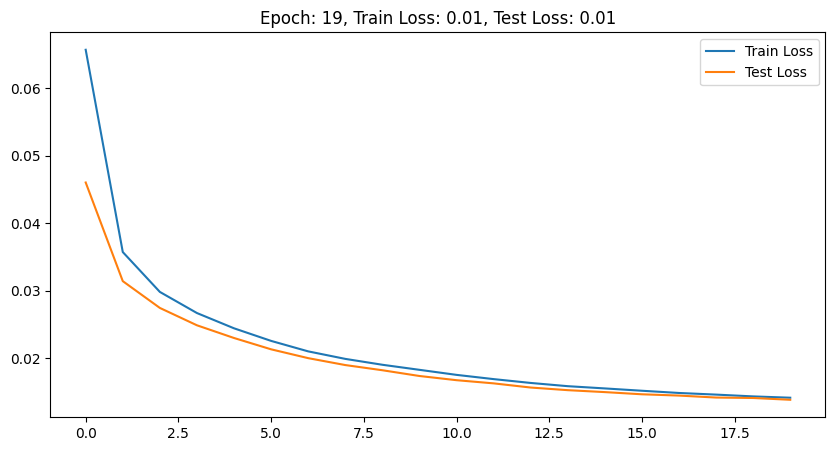

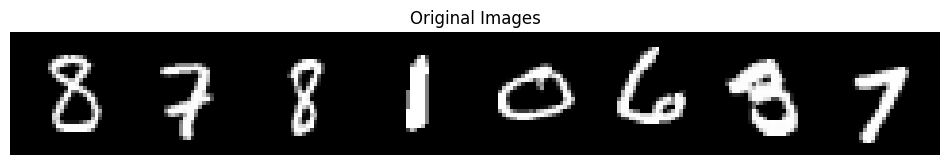

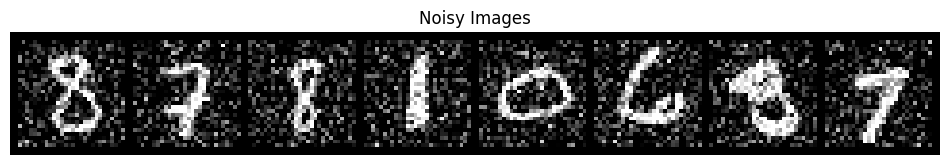

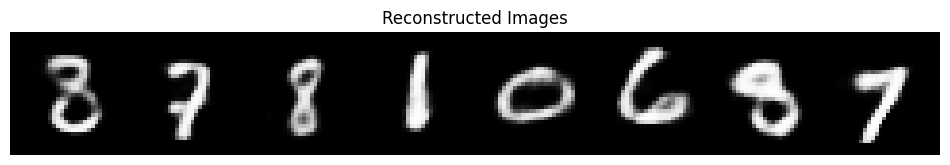

CPU times: user 3min 12s, sys: 6.88 s, total: 3min 19s
Wall time: 3min 16s


In [ ]:
# Обучение и валидация модели
%%time

torch.manual_seed(42)

epochs = 20
train_losses, test_losses = train_autoencoder(
    autoencoder,
    train_loader,
    test_loader,
    loss_fn,
    opt,
    epochs=epochs,
    print_every=1
)

# Сверточная модель

In [ ]:
images, indexes = next(iter(train_loader))

images.shape, indexes.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
# Гиперпараметры
batch_size = 128
input_size = (1, 28, 28)
hidden_size = 64
kernel_size = 3
latent_size = 128
lr = 0.001
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Класс модели сверточного автоэнкодера

In [ ]:
class ConvAutoEncoder(nn.Module):
    def __init__(self,
                 input_size: Tuple[int],  # размерность входных картинок
                 hidden_size: int,  # размерность первой свертки, дальше умножаются на 2
                 kernel_size: int,  # размерность ядра сверток
                 latent_size: int,  # размерность выхода энкодера
                 ):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.latent_size = latent_size

        # сеть энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(self.input_size[0], hidden_size, kernel_size, stride=2, padding=1), # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size * 2, kernel_size, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(hidden_size * 2, hidden_size * 4, kernel_size, stride=2, padding=0), # 7x7 -> 3x3
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(hidden_size * 4 * 3 * 3, latent_size)
        )

        # сеть декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size * 4 * 3 * 3),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(hidden_size * 4, 3, 3)),
            nn.ConvTranspose2d(hidden_size * 4, hidden_size * 2, kernel_size, stride=2, padding=0), #3x3 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_size * 2, hidden_size, kernel_size, stride=2, padding=1, output_padding=1), # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_size, self.input_size[0], kernel_size, stride=2, padding=1, output_padding=1), #14x14 -> 28x28
            nn.Sigmoid(),
        )

    # forward pass через энкодер и декодер
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon

    # forward pass через энкодер на инференсе
    @torch.inference_mode()
    def encode(self, image: torch.Tensor) -> torch.Tensor:
        latent = self.encoder(image)
        return latent

    # forward pass через декодер на инференсе
    @torch.inference_mode()
    def decode(self, latent: torch.Tensor) -> torch.Tensor:
        recon = self.decoder(latent)
        return recon

Инициализация модели

In [ ]:
autoencoder = ConvAutoEncoder(input_size, hidden_size, kernel_size, latent_size).to(device)
opt = optim.Adam(autoencoder.parameters(), lr=lr)
loss_fn = nn.MSELoss()

Обучение автоэнкодера

In [ ]:
# Функция для добавления шума
noise_factor = 0.3
def add_noise(images: torch.Tensor, noise_factor: float) -> torch.Tensor:
    noise = torch.randn_like(images) * noise_factor
    noise_images = images + noise
    return noise_images.clip(0, 1)

In [ ]:
# Визуализация изображений
def plot_images(original_images: torch.Tensor, noisy_images: torch.Tensor, recon_images: torch.Tensor) -> None:
    titles = ['Original Images', 'Noisy Images', 'Reconstructed Images']

    for imgs, title in zip([original_images, noisy_images, recon_images], titles):
        grid = make_grid(imgs.cpu().detach()[:8], nrow=8)
        plt.figure(figsize=(12, 2))
        plt.title(title)
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
    plt.show()

In [ ]:
def train_autoencoder(
        ae: nn.Module,
        train_loader: DataLoader,
        test_loader: DataLoader,
        loss_fn: nn.Module,
        opt: torch.optim.Optimizer,
        epochs: int,
        print_every: int = 1) -> Tuple[List[float], List[float]]:

    ae.train()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        epoch_train_loss = 0

        # Обучение на тренировочной выборке
        for images, _ in train_loader:
            noisy_images = add_noise(images, noise_factor).to(device)
            images = images.to(device)

            recon_images = ae(noisy_images)
            loss = loss_fn(recon_images, images)
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Валидация на тестовой выборке
        ae.eval()
        epoch_test_loss = 0
        with torch.no_grad():
            for images, _ in test_loader:
                noisy_images = add_noise(images, noise_factor).to(device)
                images = images.to(device)

                recon_images = ae(noisy_images)
                loss = loss_fn(recon_images, images)
                epoch_test_loss += loss.item()

        avg_test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        ae.train()  # возвращаем модель в режим обучения

        # Визуализация потерь на тренировочной и тестовой выборках
        if epoch % print_every == 0:
            clear_output(True)
            plt.figure(figsize=(10, 5))
            plt.title(f'Epoch: {epoch}, Train Loss: {avg_train_loss:.2f}, Test Loss: {avg_test_loss:.2f}')
            plt.plot(train_losses, label='Train Loss')
            plt.plot(test_losses, label='Test Loss')
            plt.legend()
            plt.show()

            # Визуализация изображений
            plot_images(images, noisy_images, recon_images)

    return train_losses, test_losses

In [ ]:
autoencoder

ConvAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=2304, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(256, 3, 3))
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): Sigmoid()
  )
)

In [ ]:
# инфо о размерностях выходов каждого слоя сети
summary(autoencoder, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]             640
              ReLU-2           [-1, 64, 14, 14]               0
            Conv2d-3            [-1, 128, 7, 7]          73,856
              ReLU-4            [-1, 128, 7, 7]               0
            Conv2d-5            [-1, 256, 3, 3]         295,168
              ReLU-6            [-1, 256, 3, 3]               0
           Flatten-7                 [-1, 2304]               0
            Linear-8                  [-1, 128]         295,040
            Linear-9                 [-1, 2304]         297,216
             ReLU-10                 [-1, 2304]               0
        Unflatten-11            [-1, 256, 3, 3]               0
  ConvTranspose2d-12            [-1, 128, 7, 7]         295,040
             ReLU-13            [-1, 128, 7, 7]               0
  ConvTranspose2d-14           [-1, 64,

Обучение

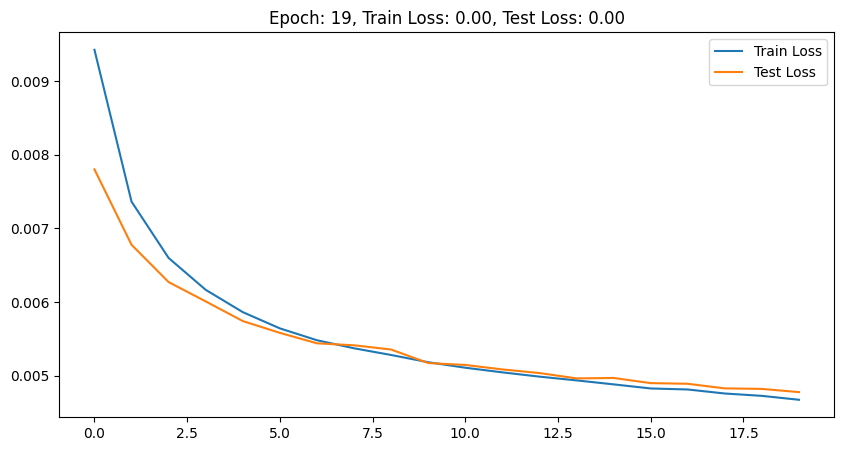

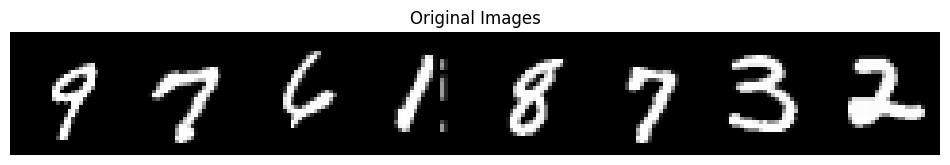

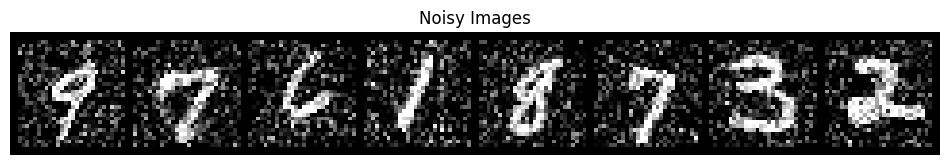

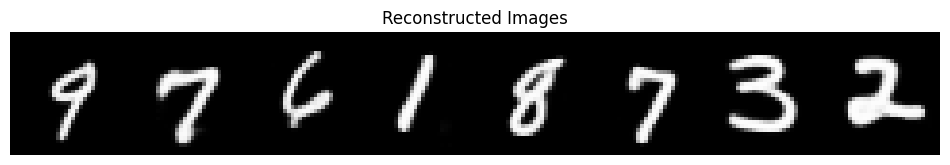

CPU times: user 4min 28s, sys: 6.77 s, total: 4min 35s
Wall time: 4min 33s


In [ ]:
# Обучение и валидация модели
%%time

train_losses, test_losses = train_autoencoder(
    autoencoder,
    train_loader,
    test_loader,
    loss_fn,
    opt,
    epochs=epochs,
    print_every=1
)